In [1]:
import pandas as pd
import isn_tractor.ibisn_lite as it
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [20]:

def analyze_network_data_old(data, type_analysis="Strength", abs_val=True, thr_values=None, label_column='label'):
    controls_list = {}
    cases_list = {}

    def preprocess_data(data, label_column):
        data.index.name = None

        if label_column is not None:
            data_controls = data[data[label_column] == 0]
            data_cases = data[data[label_column] == 1]

            # Drop the label column
            data_controls.drop([label_column], axis=1, inplace=True)
            data_cases.drop([label_column], axis=1, inplace=True)

            # Transpose the dataframes and reset the index
            cases = data_cases.T.reset_index()
            controls = data_controls.T.reset_index()

            # Split the values in the index column by "_"
            cases[['N1', 'N2']] = cases['index'].str.split("_", expand=True)
            cases.drop(['index'], axis=1, inplace=True)

            controls[['N1', 'N2']] = controls['index'].str.split("_", expand=True)
            controls.drop(['index'], axis=1, inplace=True)

            return controls, cases

        else:
            return data

    data = preprocess_data(data, label_column)

    def process_data(data, data_list, thr):
        for i in range(data.shape[1] - 2):
            temp = data.iloc[:, [data.shape[1] - 2, data.shape[1] - 1, i]].copy()
            if abs_val:
                temp.iloc[:, 2] = np.abs(temp.iloc[:, 2])
            aa = temp.columns[2]
            temp.columns = ["E1", "E2", "Weight"]
            mygraph = nx.from_pandas_edgelist(temp, "E1", "E2", "Weight")
            gg = nx.to_numpy_array(mygraph, weight="Weight")
            data_list[aa] = gg

    process_data(data[0], controls_list, thr_values)
    process_data(data[1], cases_list, thr_values)

    num_controls = len(controls_list)
    num_cases = len(cases_list)
    if thr_values is None:
        thr_values = np.arange(-4, 4, 0.03)
    FC1 = np.zeros((num_controls, len(thr_values)))
    FC2 = np.zeros((num_cases, len(thr_values)))

    def calculate_FC(data_list, FC):
        for indv in range(len(data_list)):
            nm_l = list(data_list.keys())[indv]
            Adj = data_list[nm_l]
            for i in range(len(thr_values)):
                Adj_bin = np.where((Adj > thr_values[i]) & (Adj != 0), 1, 0)
                g = nx.from_numpy_array(Adj_bin, create_using=nx.Graph)
                FC[indv, i] = g.number_of_edges()

    calculate_FC(controls_list, FC1)
    calculate_FC(cases_list, FC2)

    df_controls = pd.DataFrame({"Thr": thr_values, "Mean": np.mean(FC1, axis=0), "sd": np.std(FC1, axis=0), "cl": ["Controls"] * len(thr_values)})
    df_cases = pd.DataFrame({"Thr": thr_values, "Mean": np.mean(FC2, axis=0), "sd": np.std(FC2, axis=0), "cl": ["Cases"] * len(thr_values)})
    df = pd.concat([df_controls, df_cases])

    plt.figure(figsize=(12, 10))
    color_mapping = {'Cases': 'red', 'Controls': 'blue'}
    plt.errorbar(df_controls["Thr"], df_controls["Mean"], yerr=df_controls["sd"], elinewidth=0.5)
    plt.errorbar(df_cases["Thr"], df_cases["Mean"], yerr=df_cases["sd"], elinewidth=0.5, color="red")

    # Add labels to the x-axis and y-axis
    plt.xlabel("Threshold Values")
    plt.ylabel("Graph Statistic: Strength")

    # Create legend based on color_mapping
    labels = list(color_mapping.keys())
    handles = [plt.Line2D([], [], color=color_mapping[label], marker='o', linestyle='-') for label in labels]
    plt.legend(handles, labels)

    plt.show()


def analyze_network_data(data, type_analysis="Strength", abs_val=True, thr_values=None, label_column='label'):
    data_list = {}

    def preprocess_data(data, label_column):
        data.index.name = None

        if label_column is not None:
            unique_labels = data[label_column].unique()
            for label in unique_labels:
                data_label = data[data[label_column] == label]
                data_label.drop([label_column], axis=1, inplace=True)
                data_label = data_label.T.reset_index()
                print(data_label.iloc[:5,:5])
                data_label[['N1', 'N2']] = data_label['index'].str.split("_", expand=True)
                data_label.drop(['index'], axis=1, inplace=True)
                data_list[label] = data_label

        else:
            data_list["data"] = data.T.reset_index()
            data_list["data"][['N1', 'N2']] = data_list["data"]['index'].str.split("_", expand=True)
            data_list["data"].drop(['index'], axis=1, inplace=True)

    preprocess_data(data, label_column)

    num_labels = len(data_list)
    if thr_values is None:
        thr_values = np.arange(0.02, 4, 0.03)

    FC = np.zeros((num_labels, len(thr_values)))

    def calculate_FC(data_list, FC):
        for indv, label in enumerate(data_list):
            data_label = data_list[label]
            Adj = nx.from_pandas_edgelist(data_label, "N1", "N2", "Weight")
            for i in range(len(thr_values)):
                Adj_bin = np.where((Adj < thr_values[i]) & (Adj > 0), 1, 0)
                g = nx.from_numpy_array(Adj_bin, create_using=nx.Graph)
                FC[indv, i] = g.size()

    calculate_FC(data_list, FC)

    df = pd.DataFrame({"Thr": thr_values})
    for indv, label in enumerate(data_list):
        df_label = pd.DataFrame({"Mean": np.mean(FC[indv], axis=0), "sd": np.std(FC[indv], axis=0), "cl": [label] * len(thr_values)})
        df = pd.concat([df, df_label], axis=1)

    plt.figure(figsize=(12, 10))
    color_mapping = {label: plt.get_cmap('tab10')(idx) for idx, label in enumerate(data_list)}
    for label in data_list:
        plt.errorbar(df["Thr"], df[label]["Mean"], yerr=df[label]["sd"], elinewidth=0.5, color=color_mapping[label])

    # Add labels to the x-axis and y-axis
    plt.xlabel("Threshold Values")
    plt.ylabel("Graph Statistic: Strength")

    # Create legend based on color_mapping
    handles = [plt.Line2D([], [], color=color_mapping[label], marker='o', linestyle='-') for label in data_list]
    plt.legend(handles, data_list.keys())

    plt.show()


In [3]:
expr = pd.read_csv("expression.csv")
expr
clinic = pd.read_csv("answer.csv")
expr.shape, clinic.shape

((53, 10001), (53, 3))

In [22]:
clinic
clinic['mets'] = clinic['mets'].replace({'yes': 1, 'no': 0})
clinic[["mets"]]

,mets
0,1
1,1
2,1
3,1
4,0
5,1
6,1
7,0
8,1
9,0


In [ ]:
def read_txt_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]

    return lines

# Replace 'file_path.txt' with the path to your text file
file_path = 'topEdges_names.txt'
Edge_top50 = read_txt_file(file_path)
Nodes_top = read_txt_file('topNodes_names.txt')


In [12]:
expr_red = expr.loc[:, Nodes_top]
expr_red

,BGLAP,MMP11,MFAP4,FKSG30,CSPG2,MXRA5,COL8A1,H19,PTHR1,DSPG3,...,SP7,EFHD1,CCDC3,SEPP1,CD36,GYG2,ID3,FOSB,SLC29A4,TNFSF10
0,8.376805,8.492702,7.385375,10.041198,9.277826,9.523116,7.700297,10.596570,12.137061,7.440423,...,10.397861,11.466137,11.453714,11.589736,10.158793,9.327614,13.008999,9.034850,7.660849,8.414350
1,11.814353,12.080326,9.538171,12.928094,12.464073,12.724130,10.608841,11.902021,11.774692,8.137969,...,9.032711,8.965553,8.248110,13.306324,9.120152,7.935289,11.307627,7.516208,7.677835,10.137616
2,9.218758,9.257661,7.392345,10.019886,9.231960,11.443006,7.851336,10.248198,11.354432,10.170542,...,10.421086,7.763161,11.173293,10.261599,8.638173,9.653094,11.989641,8.605292,8.692334,8.354612
3,11.399848,12.085068,8.301253,8.974140,8.923994,12.519086,11.698145,11.828618,10.860999,11.797987,...,10.042881,10.014531,11.259219,10.999518,9.736293,8.417690,11.730339,9.604605,8.268832,11.339873
4,10.856480,10.178739,7.939469,9.885070,9.013158,12.364219,9.323162,11.324698,12.538498,8.375326,...,11.165091,9.846616,11.294569,11.620373,9.521489,10.863179,12.921022,9.030893,8.904637,8.833967
5,8.763186,11.260716,8.106863,10.774783,9.020810,12.720959,10.144535,10.074671,9.926358,10.060367,...,7.654535,7.449470,8.582728,9.701420,8.004621,8.424989,10.295495,8.996872,7.542102,9.111227
6,12.306729,8.998086,7.395088,8.939408,8.460357,9.560943,9.915053,10.555542,12.551299,7.427949,...,11.725042,8.281010,10.883080,10.821299,9.571409,9.112122,12.612244,7.424350,8.264615,8.067293
7,8.307258,9.427902,9.215378,10.160267,9.708172,11.609660,9.429717,11.903506,8.643370,7.895358,...,7.432428,7.623674,8.133813,10.314660,7.751468,8.007932,10.615647,7.773104,8.014349,9.497911
8,10.381877,8.772431,10.300032,8.708050,10.490149,12.599945,12.107883,10.921195,11.857621,8.002712,...,9.776503,7.853093,10.033356,9.784136,9.064645,8.296031,11.337043,8.017291,7.507090,8.946449
9,11.522609,8.081873,7.475995,12.222545,11.681222,11.166657,8.860198,12.223239,11.697732,7.653558,...,10.672710,9.632433,9.495805,13.066609,11.696870,8.764980,12.795677,7.460399,7.530893,9.418052


In [5]:
expr_red = expr# .iloc[:, list(range(101)) + [10000]]
expr_red


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V492,V493,V494,V495,V496,V497,V498,V499,V500,target
0,11.298475,12.727493,7.529003,7.663073,14.282365,14.170857,14.156327,7.371697,15.402461,15.545740,...,8.967323,8.055280,7.332254,7.781637,10.028974,9.163364,8.855034,8.414350,13.700638,1
1,14.382804,12.279038,13.117282,11.071374,7.455150,7.466276,14.715326,7.603332,7.389277,7.422667,...,7.324497,9.639552,8.949238,9.231484,11.569211,11.309960,10.108997,10.137616,11.847397,1
2,7.419314,13.098738,8.013840,7.499774,7.464795,7.462882,15.268260,11.901249,7.431686,7.427999,...,7.285432,8.538655,7.723655,7.589496,10.426221,9.209150,9.238881,8.354612,10.981975,1
3,13.264524,7.306185,11.198390,7.783404,7.440524,7.490984,15.803180,11.143242,11.074048,7.624282,...,7.300162,8.167766,9.545348,7.498125,10.075448,12.543117,10.892221,11.339873,12.311793,1
4,12.653608,12.940404,8.336544,7.514510,12.779227,12.404029,13.862523,12.183529,10.937346,11.127103,...,10.339968,8.406767,7.584267,7.507509,9.331176,10.140920,9.648381,8.833967,12.139652,0
5,7.439344,12.628733,7.985869,7.475089,12.280219,12.071012,14.318936,7.333865,13.715684,13.936119,...,8.423031,8.622029,9.134427,7.524423,10.149362,10.785965,9.037867,9.111227,11.643126,1
6,12.919714,7.334109,9.220762,7.416399,8.890590,8.634837,14.568654,13.066225,8.594941,8.788196,...,7.312380,9.131297,8.931987,7.757804,10.433017,9.212246,8.857261,8.067293,13.791909,1
7,13.135003,13.094411,7.513726,7.360039,7.421582,7.378467,13.224991,7.363218,7.432833,7.424772,...,7.296019,8.519639,7.455687,7.557697,10.149761,11.162107,10.456029,9.497911,11.574305,0
8,14.623530,13.390385,10.777512,13.740521,7.386646,7.454139,15.636736,7.447138,7.398644,7.388321,...,7.285763,8.879330,8.934668,7.499121,10.002956,9.694218,9.781018,8.946449,12.200673,1
9,12.416811,12.962003,7.448655,7.405564,8.360782,8.302695,15.381626,9.344043,7.449698,7.468414,...,7.263206,9.845954,8.756421,9.376138,11.381313,9.783374,8.738989,9.418052,12.511716,0


In [6]:
expr_red.shape

(53, 501)

In [13]:

#expr_val = expr_red.drop('target', axis=1)

ISNs = pd.DataFrame(it.dense_isn(expr_red)).astype(float)
ISNs

,0,1,2,3,4,5,6,7,8,9,...,3590,3591,3592,3593,3594,3595,3596,3597,3598,3599
0,1.000008,0.641798,0.766256,0.243180,0.522127,1.549627,1.185010,0.709309,-0.111456,0.651334,...,-0.645000,-0.797606,-0.713518,-0.195346,-0.439941,-0.419800,-0.726250,-0.156232,0.369438,1.000000
1,1.000000,1.886800,0.243593,1.992661,1.857019,0.283286,0.440123,0.342966,0.376949,-0.514788,...,-0.781736,-0.333633,-1.326475,1.937591,-0.498517,-1.061768,-0.407707,-0.769598,-0.898698,0.999992
2,1.000008,0.024638,0.270932,-0.083993,0.070511,0.207693,0.384621,0.432106,0.392715,-0.337147,...,-0.653999,0.664696,-0.709658,0.417677,0.362761,-0.556023,-0.455097,0.008891,-0.251380,1.000000
3,1.000000,1.507184,-0.495546,-1.186747,-1.054280,0.093295,1.079701,0.339365,-0.172922,2.767829,...,1.286392,1.973911,3.083549,-0.098059,0.720124,-0.639380,0.840714,1.671911,-0.221285,1.000000
4,1.000000,0.069360,-0.474136,-0.598869,-0.756424,0.004217,-0.302983,0.133894,0.698868,-0.246996,...,-0.462183,-0.322701,-0.369854,0.038039,-0.229336,-0.175983,-0.283150,-0.004261,-0.220340,1.000000
5,1.000000,-0.513293,0.327252,-0.217471,0.434023,-0.084262,0.065421,0.672119,0.662575,-0.586819,...,-0.011391,-0.164181,-0.263773,-0.022932,-0.178743,-0.374693,-0.230782,0.087253,-0.201773,1.000000
6,1.000004,-0.842686,-1.577055,-1.714336,-1.861845,-3.362966,-0.215530,-1.342623,0.961809,-1.359034,...,-1.041029,0.573241,-0.724817,0.150631,-0.131332,-0.236427,-0.870754,0.705667,0.107810,1.000000
7,1.000000,0.167951,-0.001625,0.199167,0.280395,0.471747,0.413791,0.069941,1.056919,0.388779,...,-0.476048,-0.636808,-0.631128,-0.108361,-0.675328,-0.619663,-0.589102,-0.210629,-0.362795,0.999992
8,1.000000,-0.348831,0.261767,-0.555797,-0.238625,0.087241,0.558680,0.087381,0.467630,-0.306007,...,-0.557522,-0.070202,-0.404739,0.135297,-0.198189,-0.254904,-0.305130,0.068240,-0.047017,0.999992
9,0.999992,-1.231631,-1.039732,0.998391,0.834072,-0.959821,-0.901202,0.598368,0.366287,-0.833929,...,-0.193373,-0.124395,-0.512829,0.621350,0.873899,-0.442318,0.315639,-0.264599,-0.466793,1.000000


In [15]:
a = np.repeat(expr_red.columns, expr_red.shape[1])
b = np.tile(expr_red.columns, expr_red.shape[1])
ISNs.columns = [a[i]+'_'+b[i] for i in range(expr_red.shape[1]**2)]
print(ISNs.shape)

(53, 3600)


In [18]:
Edge_top50

['BGLAP_MMP11',
 'MFAP4_FKSG30',
 'MFAP4_CSPG2',
 'CSPG2_MXRA5',
 'COL8A1_H19',
 'PTHR1_DSPG3',
 'CXCL10_HOMER2',
 'CSPG2_DDIT4L',
 'TMSL8_SRPX',
 'BGLAP_HLA-DQB1',
 'PRSS35_HLA-DQB1',
 'AEBP1_SERPINE2',
 'FBLN2_CD248',
 'SULF1_CD248',
 'PHGDH_CDKN2A',
 'BGLAP_GZMA',
 'MFI2_GZMA',
 'RPS4Y1_SLC2A3',
 'FOS_SCIN',
 'CXCL9_SCIN',
 'SRPX_SCIN',
 'ENPP2_IFIT3',
 'TMSL8_SNAI2',
 'SULF1_SNAI2',
 'SNAI2_VWF',
 'ADM_LEPREL1',
 'SCRG1_AXL',
 'PLTP_IGFBP3',
 'MFAP4_SBDS',
 'SOST_STAT1',
 'IBSP_STAT1',
 'MEPE_STAT1',
 'IFITM5_STAT1',
 'KSP37_STAT1',
 'CDH15_STAT1',
 'PTHR1_STAT1',
 'TMEM119_STAT1',
 'SP7_STAT1',
 'MFI2_STAT1',
 'EFHD1_STAT1',
 'CCDC3_STAT1',
 'SEPP1_STAT1',
 'CD36_STAT1',
 'HOMER2_STAT1',
 'GYG2_STAT1',
 'ENPP2_STAT1',
 'ID3_STAT1',
 'SCIN_STAT1',
 'FOSB_SLC29A4',
 'SRPX_TNFSF10']

In [19]:
ISNs_top50 = ISNs.loc[:, Edge_top50]
ISNs_top50

,BGLAP_MMP11,MFAP4_FKSG30,MFAP4_CSPG2,CSPG2_MXRA5,COL8A1_H19,PTHR1_DSPG3,CXCL10_HOMER2,CSPG2_DDIT4L,TMSL8_SRPX,BGLAP_HLA-DQB1,...,CCDC3_STAT1,SEPP1_STAT1,CD36_STAT1,HOMER2_STAT1,GYG2_STAT1,ENPP2_STAT1,ID3_STAT1,SCIN_STAT1,FOSB_SLC29A4,SRPX_TNFSF10
0,0.641798,0.504648,0.853662,1.167473,1.097080,-0.464795,0.319163,0.647703,-1.323883,0.062316,...,0.001818,-0.049767,-0.042618,-0.089039,-0.139601,-0.088789,0.036434,0.252409,-0.221392,0.530984
1,1.886800,0.275692,0.265402,0.326565,0.236828,-0.151212,-0.446455,0.783797,-0.582327,2.421968,...,-0.066339,0.167064,-0.089342,-0.214393,-0.124924,-0.028599,-0.164280,-0.160417,0.601500,0.576209
2,0.024638,0.517723,0.881114,0.744101,1.406609,-0.057858,-0.372206,0.801260,-0.350670,0.135101,...,-0.300657,0.052788,0.149995,-0.311417,-0.254936,-0.087763,-0.230595,0.059261,0.114666,-0.505547
3,1.507184,0.625956,0.556595,0.079836,0.248182,-0.726794,1.199114,-0.176077,-0.623453,0.225021,...,1.499875,0.127208,0.204040,1.282603,-0.833543,0.839092,0.198952,-1.395678,-0.093625,1.945061
4,0.069360,0.378572,0.727813,0.220823,0.254874,-0.206210,-0.122026,-0.451120,0.110950,0.106794,...,-0.163801,-0.131425,-0.071446,-0.223004,-0.120877,-0.035177,-0.160453,-0.181023,0.226879,0.031367
5,-0.513293,-0.085167,0.633777,-0.041498,0.038414,-0.993717,1.739272,0.319855,-1.549774,0.635792,...,2.059759,1.661265,2.281886,2.662919,1.029231,0.451092,2.126722,1.614871,-0.247757,0.157543
6,-0.842686,1.366416,1.384827,2.126852,0.222280,-0.708319,2.155769,1.681117,-1.551971,-1.777765,...,-0.473574,-0.031564,-0.054265,-0.952908,-0.134045,-0.425227,-0.627358,-0.384815,0.246661,1.074346
7,0.167951,-0.131851,0.052799,0.568296,0.056290,1.108846,-1.318907,0.009171,-0.020866,-1.101309,...,-1.231950,-0.447977,-1.274185,-0.900358,-0.827455,-0.539279,-0.796152,-0.827994,0.323534,0.070781
8,-0.348831,-0.871861,0.052528,0.373709,-0.686712,-0.197988,0.534804,0.079466,0.077123,-0.020710,...,-0.127622,0.066872,-0.010167,0.129423,-0.022574,-0.139390,-0.117913,-0.211018,0.386766,0.086158
9,-1.231631,-0.912816,-0.761634,-0.611290,-0.281359,-0.187895,0.631094,0.179977,-1.058209,-1.202326,...,-0.097798,-0.042741,-0.046559,-0.228084,-0.134148,-0.001658,-0.122113,-0.157969,0.722212,-0.225545


In [25]:
clinic

,Unnamed: 0,sample,mets
0,1,L1016,1
1,2,L1085,1
2,3,L1368,1
3,4,L1369,1
4,5,L1370,0
5,6,L1372,1
6,7,L1376,1
7,8,L1382,0
8,9,L1385,1
9,10,L1386,0


In [ ]:
# Filtration curve
ISNs_top50 = ISNs_top50.rename(index=clinic["sample"])
df = pd.concat([ISNs_top50.T, clinic['mets']], axis=1)
analyze_network_data_old(df, label_column='mets', abs_val=False)

In [27]:
ISNs_top50 = ISNs_top50.rename(index=clinic["sample"])
ISNs_top50

,BGLAP_MMP11,MFAP4_FKSG30,MFAP4_CSPG2,CSPG2_MXRA5,COL8A1_H19,PTHR1_DSPG3,CXCL10_HOMER2,CSPG2_DDIT4L,TMSL8_SRPX,BGLAP_HLA-DQB1,...,CCDC3_STAT1,SEPP1_STAT1,CD36_STAT1,HOMER2_STAT1,GYG2_STAT1,ENPP2_STAT1,ID3_STAT1,SCIN_STAT1,FOSB_SLC29A4,SRPX_TNFSF10
L1016,0.641798,0.504648,0.853662,1.167473,1.097080,-0.464795,0.319163,0.647703,-1.323883,0.062316,...,0.001818,-0.049767,-0.042618,-0.089039,-0.139601,-0.088789,0.036434,0.252409,-0.221392,0.530984
L1085,1.886800,0.275692,0.265402,0.326565,0.236828,-0.151212,-0.446455,0.783797,-0.582327,2.421968,...,-0.066339,0.167064,-0.089342,-0.214393,-0.124924,-0.028599,-0.164280,-0.160417,0.601500,0.576209
L1368,0.024638,0.517723,0.881114,0.744101,1.406609,-0.057858,-0.372206,0.801260,-0.350670,0.135101,...,-0.300657,0.052788,0.149995,-0.311417,-0.254936,-0.087763,-0.230595,0.059261,0.114666,-0.505547
L1369,1.507184,0.625956,0.556595,0.079836,0.248182,-0.726794,1.199114,-0.176077,-0.623453,0.225021,...,1.499875,0.127208,0.204040,1.282603,-0.833543,0.839092,0.198952,-1.395678,-0.093625,1.945061
L1370,0.069360,0.378572,0.727813,0.220823,0.254874,-0.206210,-0.122026,-0.451120,0.110950,0.106794,...,-0.163801,-0.131425,-0.071446,-0.223004,-0.120877,-0.035177,-0.160453,-0.181023,0.226879,0.031367
L1372,-0.513293,-0.085167,0.633777,-0.041498,0.038414,-0.993717,1.739272,0.319855,-1.549774,0.635792,...,2.059759,1.661265,2.281886,2.662919,1.029231,0.451092,2.126722,1.614871,-0.247757,0.157543
L1376,-0.842686,1.366416,1.384827,2.126852,0.222280,-0.708319,2.155769,1.681117,-1.551971,-1.777765,...,-0.473574,-0.031564,-0.054265,-0.952908,-0.134045,-0.425227,-0.627358,-0.384815,0.246661,1.074346
L1382,0.167951,-0.131851,0.052799,0.568296,0.056290,1.108846,-1.318907,0.009171,-0.020866,-1.101309,...,-1.231950,-0.447977,-1.274185,-0.900358,-0.827455,-0.539279,-0.796152,-0.827994,0.323534,0.070781
L1385,-0.348831,-0.871861,0.052528,0.373709,-0.686712,-0.197988,0.534804,0.079466,0.077123,-0.020710,...,-0.127622,0.066872,-0.010167,0.129423,-0.022574,-0.139390,-0.117913,-0.211018,0.386766,0.086158
L1386,-1.231631,-0.912816,-0.761634,-0.611290,-0.281359,-0.187895,0.631094,0.179977,-1.058209,-1.202326,...,-0.097798,-0.042741,-0.046559,-0.228084,-0.134148,-0.001658,-0.122113,-0.157969,0.722212,-0.225545


In [30]:
clinic['mets']

L1016    1
L1085    1
L1368    1
L1369    1
L1370    0
L1372    1
L1376    1
L1382    0
L1385    1
L1386    0
L2292    0
L2295    0
L2296    1
L2297    0
L2301    1
L2302    0
L2611    0
L2614    1
L2616    1
L2618    1
L2619    1
L2620    0
L3431    1
L3432    1
L3433    1
L3434    1
L3435    1
L3436    1
L3437    1
L3438    1
L3439    1
L3440    1
L3441    1
L3442    1
L3443    0
L3444    0
L3445    0
L3446    1
L3447    1
L3448    1
L3449    1
L3460    1
L3463    1
L3465    1
L3470    1
L3475    0
L3477    0
L3534    1
L428     0
L432     0
L436     0
L975     0
L997     0
Name: mets, dtype: int64

In [29]:
# Filtration curve
#ISNs_top50 = ISNs_top50.rename(index=ISNs_top50["sample"])
# Filtration curve
ISNs_top50 = ISNs_top50.rename(index=clinic["sample"])
clinic = clinic.rename(index=clinic["sample"])

df = pd.concat([ISNs_top50, clinic['mets']], axis=1)
df

,L1016,L1085,L1368,L1369,L1370,L1372,L1376,L1382,L1385,L1386,...,L3470,L3475,L3477,L3534,L428,L432,L436,L975,L997,mets
BGLAP_MMP11,0.641798,1.886800,0.024638,1.507184,0.069360,-0.513293,-0.842686,0.167951,-0.348831,-1.231631,...,1.410615,-0.078118,-0.378018,-0.128939,-0.557005,-2.425666,0.186295,-1.501446,-0.258170,NaN
MFAP4_FKSG30,0.504648,0.275692,0.517723,0.625956,0.378572,-0.085167,1.366416,-0.131851,-0.871861,-0.912816,...,-0.025820,0.437389,0.876664,0.718487,-1.401499,0.165790,-0.039921,-1.204311,-1.414686,NaN
MFAP4_CSPG2,0.853662,0.265402,0.881114,0.556595,0.727813,0.633777,1.384827,0.052799,0.052528,-0.761634,...,-0.928430,0.145401,1.414409,0.299970,-1.697366,-0.388739,0.178139,-1.335807,-0.068888,NaN
CSPG2_MXRA5,1.167473,0.326565,0.744101,0.079836,0.220823,-0.041498,2.126852,0.568296,0.373709,-0.611290,...,-0.007740,-0.310087,0.756979,0.533581,-0.511320,-0.242498,0.100292,-0.373655,0.215651,NaN
COL8A1_H19,1.097080,0.236828,1.406609,0.248182,0.254874,0.038414,0.222280,0.056290,-0.686712,-0.281359,...,0.025661,-2.534453,-0.958180,0.784286,0.613955,0.048499,0.161283,-0.253518,0.949475,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
L432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
L436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
L975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


C:\Users\fmelo\AppData\Local\Temp\ipykernel_6020\663212443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_controls.drop([label_column], axis=1, inplace=True)
C:\Users\fmelo\AppData\Local\Temp\ipykernel_6020\663212443.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cases.drop([label_column], axis=1, inplace=True)


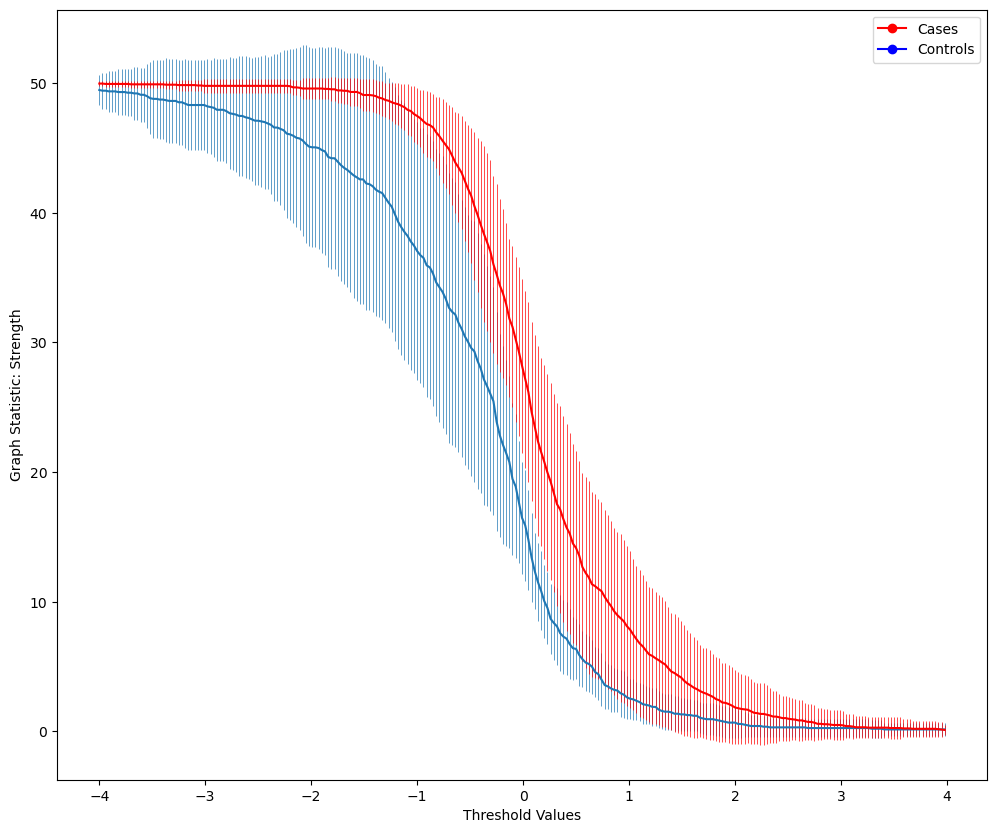

In [32]:
analyze_network_data_old(df, label_column='mets', abs_val=False)

In [9]:
expr_red

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V492,V493,V494,V495,V496,V497,V498,V499,V500,target
0,11.298475,12.727493,7.529003,7.663073,14.282365,14.170857,14.156327,7.371697,15.402461,15.545740,...,8.967323,8.055280,7.332254,7.781637,10.028974,9.163364,8.855034,8.414350,13.700638,1
1,14.382804,12.279038,13.117282,11.071374,7.455150,7.466276,14.715326,7.603332,7.389277,7.422667,...,7.324497,9.639552,8.949238,9.231484,11.569211,11.309960,10.108997,10.137616,11.847397,1
2,7.419314,13.098738,8.013840,7.499774,7.464795,7.462882,15.268260,11.901249,7.431686,7.427999,...,7.285432,8.538655,7.723655,7.589496,10.426221,9.209150,9.238881,8.354612,10.981975,1
3,13.264524,7.306185,11.198390,7.783404,7.440524,7.490984,15.803180,11.143242,11.074048,7.624282,...,7.300162,8.167766,9.545348,7.498125,10.075448,12.543117,10.892221,11.339873,12.311793,1
4,12.653608,12.940404,8.336544,7.514510,12.779227,12.404029,13.862523,12.183529,10.937346,11.127103,...,10.339968,8.406767,7.584267,7.507509,9.331176,10.140920,9.648381,8.833967,12.139652,0
5,7.439344,12.628733,7.985869,7.475089,12.280219,12.071012,14.318936,7.333865,13.715684,13.936119,...,8.423031,8.622029,9.134427,7.524423,10.149362,10.785965,9.037867,9.111227,11.643126,1
6,12.919714,7.334109,9.220762,7.416399,8.890590,8.634837,14.568654,13.066225,8.594941,8.788196,...,7.312380,9.131297,8.931987,7.757804,10.433017,9.212246,8.857261,8.067293,13.791909,1
7,13.135003,13.094411,7.513726,7.360039,7.421582,7.378467,13.224991,7.363218,7.432833,7.424772,...,7.296019,8.519639,7.455687,7.557697,10.149761,11.162107,10.456029,9.497911,11.574305,0
8,14.623530,13.390385,10.777512,13.740521,7.386646,7.454139,15.636736,7.447138,7.398644,7.388321,...,7.285763,8.879330,8.934668,7.499121,10.002956,9.694218,9.781018,8.946449,12.200673,1
9,12.416811,12.962003,7.448655,7.405564,8.360782,8.302695,15.381626,9.344043,7.449698,7.468414,...,7.263206,9.845954,8.756421,9.376138,11.381313,9.783374,8.738989,9.418052,12.511716,0


C:\Users\fmelo\AppData\Local\Temp\ipykernel_37132\2493541851.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_controls.drop([label_column], axis=1, inplace=True)
C:\Users\fmelo\AppData\Local\Temp\ipykernel_37132\2493541851.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cases.drop([label_column], axis=1, inplace=True)


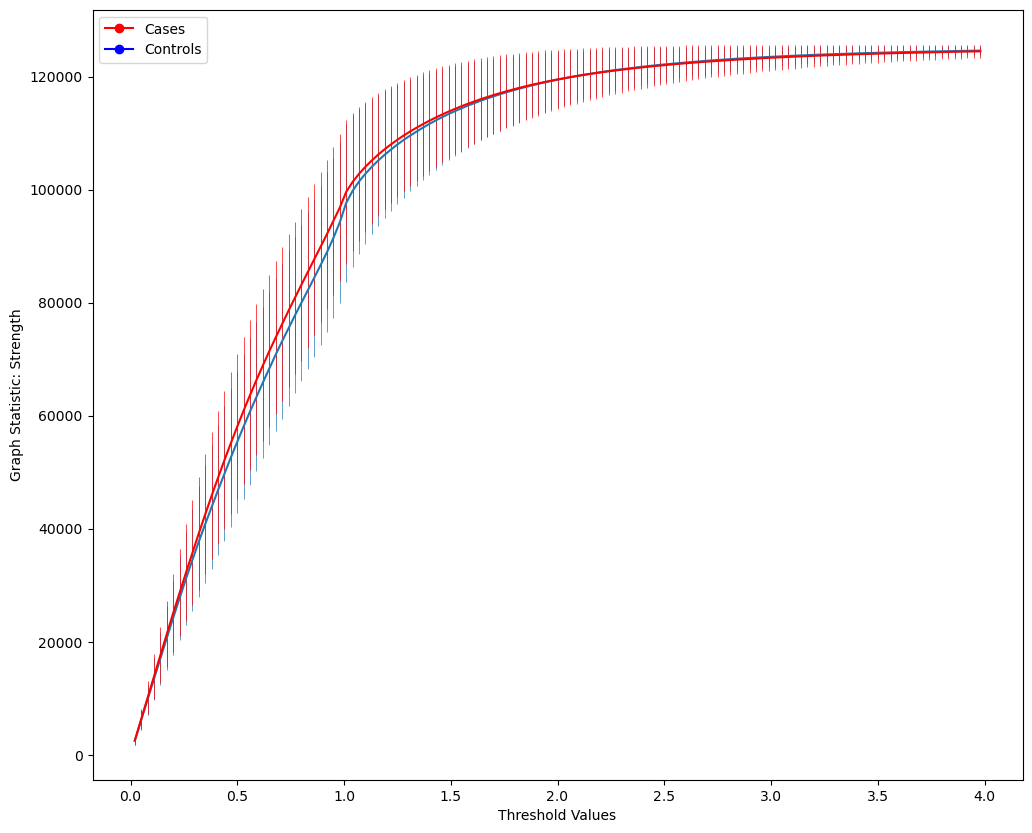

In [10]:
# Filtration curve
df = pd.concat([ISNs, expr_red['target']], axis=1)
analyze_network_data_old(df, label_column='target', )

In [31]:
# Filtration curve
analyze_network_data_old(expr_red, label_column='target')

C:\Users\fmelo\AppData\Local\Temp\ipykernel_33244\2493541851.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_controls.drop([label_column], axis=1, inplace=True)
C:\Users\fmelo\AppData\Local\Temp\ipykernel_33244\2493541851.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cases.drop([label_column], axis=1, inplace=True)


ValueError: Columns must be same length as key